## Portfolio Optimalization - Asset Management
#### Arno Goedhuys /  r0636556 / 29 juni 2017

In [17]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm
%matplotlib inline

#### Downloading the data
The data is downloaded from google finance. 
<p> The time interval runs from the first of january 2009 to the current date.

In [2]:
assets = ['AAPL','MSFT','AMZN','YHOO']
amount_of_assets = len(assets)
pf_data = pd.DataFrame()

for asset in assets:
    pf_data[asset] = wb.DataReader(asset, data_source = 'google', start='2009-1-1')['Close']

In [3]:
pf_data.tail()

,AAPL,MSFT,AMZN,YHOO
Date,,,,
2017-07-13,147.77,71.77,1000.63,56.46
2017-07-14,149.04,72.78,1001.81,57.23
2017-07-17,149.56,73.35,1010.04,57.51
2017-07-18,150.08,73.30,1024.45,58.48
2017-07-19,151.02,73.86,1026.87,58.36


#### Normalize data
Devide each value of each asset by its initial value and multipy by 100 so each asset starts with a value of 100. <p> Plot the evolution of each asset.

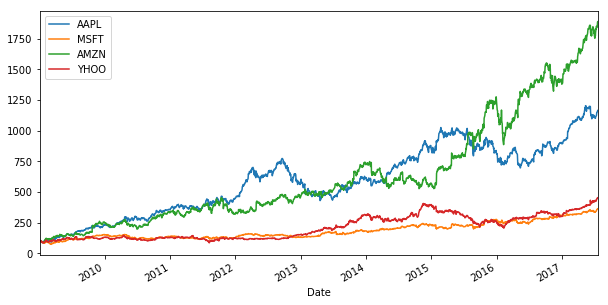

In [4]:
normalized_data = pf_data / pf_data.iloc[0] * 100
(normalized_data).plot(figsize=(10,5))

#### Calculate the return and risk of a portfolio given the portfolio's assets and their respective weights
A function to generate a given amount of random weights while making sure the sum of the weights equals 1.

In [5]:
def gen_random_weights(amount):
    weights = np.random.random(amount)
    weights /= np.sum(weights)
    return weights
print gen_random_weights(amount_of_assets)

[ 0.15043926  0.07416228  0.20434251  0.57105596]


A function to calculate the expected annual return of the portfolio.
The expected annual return of a portfolio can be calculated as: $$ p = w^T*E(r) $$
Where w is the weights of the respective portfolios and E(r) the expected anual returns of the assets.
The expected anual return of an individual asset is calculated as the expected daily return times 252 which is the amount of trading days. The expected daily return is calculated as the expected value of the logarithm of the assets current value devided by its previous value. So the expected anual return of an asset is given by: $$ E(r) = 252 * E(\log(P_i/P_{i+1})) $$
Where $P_i$ represents the assets price on day i and $P_{i+1}$ the assets price on day i+1.

In [6]:
def portfolio_return(assets, weights):
    log_returns = np.log(assets / assets.shift(1))
    annual_returns = log_returns.mean() * 252
    total_return = np.sum(annual_returns * weights)
    return total_return

portfolio_return(normalized_data, gen_random_weights(amount_of_assets))

0.2310955766214488

A function to calculate the expected volatility of a portfolio. The volatility is modelled as the standard deviation of portfolios returns. This be calculated as: $$ \sigma^2 = w^T*C*w $$
Where w is again the weights of the assets and C is the covariance matrix of the returns.

In [7]:
def portfolio_volatility(assets, weights):
    log_returns = np.log(assets / assets.shift(1))
    cov_matrix = log_returns.cov() * 252
    total_volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
    return total_volatility

portfolio_volatility(normalized_data, gen_random_weights(amount_of_assets))

0.20814658151819809

#### Functions to return the parameters that need to be optimized with their weights as variables 
They are all calculated the same way as their numeric functions previously defined only the weights are variables instead of numeric values. Parameters that have to be maximized are taken negatively because the optimizations look for minimal values and the weights that give the maximal value are the same weights that given the minimal negative value.

The return in function of the weights.

In [8]:
def returns(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = log_returns.mean() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -np.sum(annual_returns * variable)

The risk in function of the weights.

In [9]:
def risk(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    cov_matrix = log_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))


The sharp ratio in function of the weights. The sharp ratio is the return devided by the risk.

In [10]:
def sharp(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = log_returns.mean() * 252
    cov_matrix = log_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -(np.sum(annual_returns * variable)) / (np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))) 

#### Extra funtions usefull for the optimization


The contraint for the optimization, that the sum of the weights must be equal to one. 

In [11]:
def constraint12(x):
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sum(variable) - 1

A function to generate the valid interval for each weight.

In [12]:
def gen_bounds(amount):
    bounds = []
    for i in range(amount):
        bounds.append((0,0.5))
    return bounds

Make an initial guess by brute force to give the optimazation a good starting point.

In [32]:
def initial_guess(assets, amount_of_samples):
    min_risk = 1
    min_risk_weights = gen_random_weights(amount_of_assets)
    max_sharp = 0
    max_sharp_weights = gen_random_weights(amount_of_assets)
    max_VaR = -1
    max_VaR_weights = gen_random_weights(amount_of_assets)
    for x in range(amount_of_samples):
        weights = gen_random_weights(amount_of_assets)
        port_risk = portfolio_volatility(assets, weights)
        port_return = portfolio_return(assets, weights)
        port_VaR = HistoricVaR(assets, weights, 0.05)
        if port_risk < min_risk:
            min_risk = port_risk
            min_risk_weights = weights
        if port_return/port_risk > max_sharp:
            max_sharp = port_return/port_risk
            max_sharp_weights = weights
        if port_VaR > max_VaR:
            max_VaR = port_VaR
            max_VaR_weights = weights
    return [min_risk_weights, max_sharp_weights, max_VaR_weights]

#### The optimizations
The optimization for the minimal risk portfolio. The extra constraints that each weight lies between 0 and 0.5 are set by the 
bounds attribute. The optimization used is the sequantial least squares programming. The site PyOpt explains it as:
> SLSQP optimizer is a sequential least squares programming algorithm which uses the Han–Powell quasi–Newton method with a BFGS update of the B–matrix and an L1–test function in the step–length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver. 
>
> [PyOpt](http://www.pyopt.org/reference/optimizers.slsqp.html)

In [14]:
minimal_risk_weights = optimize.fmin_slsqp(risk, initial_guess(normalized_data,1000)[0].tolist(),eqcons=[constraint12],
                     bounds=gen_bounds(amount_of_assets))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.205331146826
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 3


The optimization for the maximal sharp portfolio. The same algorithm is used as with the minimal risk.

In [15]:
maximal_sharp_weights = optimize.fmin_slsqp(sharp, initial_guess(normalized_data,1000)[1].tolist(),eqcons=[constraint12],
                     bounds=gen_bounds(amount_of_assets))
maximal_sharp_weights

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1.27290968808
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


array([  5.82859847e-01,   2.37379118e-03,   4.14385231e-01,
         3.81130187e-04])

#### The results
The two optimized portfolios are plotted on a graph with the x axis the expected risk and the y axis the expected return. To illustrate that these are valid values 25000 other portfolio's with random weights are also plotted on the same graph. Out of the 25000 random portfolio's the one with the minimal risk is selected and returned to verify with the calculated weights, the same is done for the maximal sharp. 

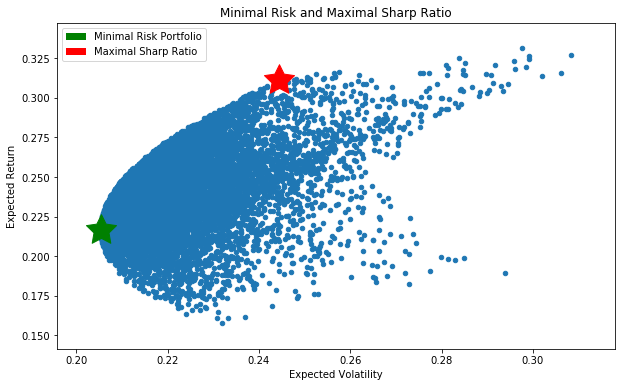

[array([ 0.33970623,  0.42105921,  0.07023087,  0.16900369]),
 array([ 0.57080544,  0.02183002,  0.40456861,  0.00279593]),
 array([ 0.3336254 ,  0.41691606,  0.07957403,  0.16988451]),
 array([  5.82859847e-01,   2.37379118e-03,   4.14385231e-01,
          3.81130187e-04])]

In [16]:
def example_plot(assets, amount_of_samples):
    returns = []
    risks = []
    min_risk = 1
    min_risk_weights = gen_random_weights(amount_of_assets)
    max_sharp = 0
    max_sharp_weights = gen_random_weights(amount_of_assets)
    for x in range(amount_of_samples):
        weights = gen_random_weights(amount_of_assets)
        port_risk = portfolio_volatility(assets, weights)
        risks.append(port_risk)
        port_return = portfolio_return(assets, weights)
        returns.append(port_return)
        if port_risk < min_risk:
            min_risk = port_risk
            min_risk_weights = weights
        if port_return/port_risk > max_sharp:
            max_sharp = port_return/port_risk
            max_sharp_weights = weights
    returns = np.array(returns)
    risks = np.array(risks)
    portfolios = pd.DataFrame({'Return': returns, 'Volatility': risks})
    portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10,6));
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    
    port_minrisk = portfolio_volatility(assets, minimal_risk_weights)
    port_return = portfolio_return(assets, minimal_risk_weights)
    plt.scatter(port_minrisk,port_return,marker=(5,1,0),color='g',s=1000)
    
    port_maxsharp = portfolio_volatility(assets, maximal_sharp_weights)
    port_return = portfolio_return(assets, maximal_sharp_weights)
    plt.scatter(port_maxsharp,port_return,marker=(5,1,0),color='r',s=1000)
    
    plt.title("Minimal Risk and Maximal Sharp Ratio")
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='g')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='r')

    plt.legend((p1, p2), ('Minimal Risk Portfolio', 'Maximal Sharp Ratio'), loc='best')
    plt.show()
    return [min_risk_weights, max_sharp_weights, minimal_risk_weights, maximal_sharp_weights]
example_plot(normalized_data, 10000)

The first array is the best minimal risk portfolio out of the 25000 random portfolios.
The third array represents the portfolio that was calculated in the minimal risk optimalization.
The second array is the best maximal sharp ratio portfolio out of the 25000 random portfolios.
The fourth array represents the portfolio that was calculated in the maximal sharp ratio optimalization.

### Different risk parameters


#### 1. VaR (Value at Risk)

Value at risk describes the worst losses at a given confidence level $ \alpha $ and over a given time period t. VaR can be calculated in two ways by taking the largest return in the $\alpha$ % interval of worst returns or by assuming the returns are normal and deriving the VaR from the mean and standard deviation.

First some functions that will be useful later are given.

In [25]:
def portfolio_daily_returns(assets, weights):
    returns = (assets.shift(1) - assets)/ assets
    portfolio_returns = returns.dot(weights)
    return portfolio_returns.drop(portfolio_returns.index[0])
portfolio_daily_returns(normalized_data, gen_random_weights(amount_of_assets)).head()

Date
2009-01-05   -0.008125
2009-01-06   -0.019191
2009-01-07    0.034960
2009-01-08   -0.024005
2009-01-09    0.020065
dtype: float64

First the VaR will be calculated by selecting the largest return in the lowest interval.

In [26]:
def HistoricVaR(assets, weights, alpha):
    return np.percentile(portfolio_daily_returns(assets,weights), alpha)
HistoricVaR(normalized_data, gen_random_weights(amount_of_assets), 0.05)

-0.06934359973320342

This method is more accurate than assuming a normal distribution because returns are not perfectly normal, but this method can not be used for optimization because every return is in function of the weights so it is unknown where the $ \alpha $ interval ends.

By assuming the returns follow a normal distribution, the VaR can be calculated as: $ VaR = \mu - F^{-1}(\alpha)* \sigma $. First a function to do this nurmerically then in function of the weights.

In [29]:
def normalVaR(assets, weights, alpha):
    var = portfolio_return(assets, weights) - norm.ppf(1-alpha) * portfolio_volatility(assets, weights)
    return var
normalVaR(normalized_data, gen_random_weights(amount_of_assets), 0.05)

-0.10678476005453974

In [40]:
def Var(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = log_returns.mean() * 252
    cov_matrix = log_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -(np.sum(annual_returns * variable) - 1.65 * np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable))))


In [41]:
minimal_Var_weights = optimize.fmin_slsqp(Var, initial_guess(normalized_data,1000)[2].tolist(),eqcons=[constraint12],
                     bounds=gen_bounds(amount_of_assets))
print minimal_Var_weights, portfolio_return(normalized_data, minimal_Var_weights),portfolio_volatility(normalized_data, minimal_Var_weights)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.088991140049
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
[ 0.5         0.11397355  0.32363314  0.06239331] 0.283809871012 0.225940006704


#### Conditional Value at risk
The Var expects the stocks returns to follow a perfect normal distribution. In reality when a stocks price falls hard it triggers other investors to sell, thus the large losses do not drop as quickly as the normal distribution supposes. Therefor it might be useful to take the expected value of the worst returns instead of the start of the 95% interval.

In [59]:
def CVaR(assets, weights, alpha):
    VaR = HistoricVaR(assets, weights, alpha)
    cVaR = np.nanmean(portfolio_daily_returns(assets, weights)[portfolio_daily_returns(assets, weights) < VaR])
    return cVaR
weight = gen_random_weights(amount_of_assets)
print CVaR(normalized_data, weight, 0.05) , HistoricVaR(normalized_data, weight, 0.05)

-0.0717708726775 -0.0670738979979
